# PID Controller Tuning

We have previously discussed many of the features that should be included in any practical implementation of PID control. The notebook addresses the core issue of how to find appropriate values for the control constants $K_P$, $K_I$, and $K_D$ in the non-interacting model for PID control

\begin{align}
MV & = \overline{MV} + K_P(\beta\ SP - PV) + K_I \int^{t} (SP - PV)\ dt + K_D \frac{d(\gamma\ SP - PV)}{dt}
\end{align}

where we have include setpoint weights $\beta$ and $\gamma$ for the proportional and derivative terms, respectively. In the case where the PID model is given in the standard ISA form

\begin{align}
MV & = \overline{MV} + K_c\left[(\beta\ SP - PV) + \frac{1}{\tau_I}\int^{t} (SP - PV)\ dt + \tau_D \frac{d(\gamma\ SP - PV)}{dt}\right]
\end{align}

the equivalent task is to find values for the control gain $K_c$, the integral time constant $\tau_I$, and derivative time constant $\tau_D$. The equivalence of these models is established by the following relationships among the parameters

\begin{align}
\begin{array}{ccc}
\mbox{ISA} \rightarrow \mbox{Non-interacting} & & \mbox{Non-interacting} \rightarrow \mbox{ISA} \\
K_P = K_c & & K_c = K_P\\
K_I = \frac{K_c}{\tau_I} & & \tau_I = \frac{K_P}{K_I}\\
K_D = K_c\tau_D & & \tau_D = \frac{K_D}{K_P}
\end{array}
\end{align}

### Empirical Methods

Determining PID control parameters is complicated by the general absence of process models for most applications. Typically the control implementation takes place in three steps:

1. **Idenfication.** A prescribed experiment is performed to create an empirical model for the response of the process to the manipulated input.
2. **Control Design.** Given an empirical model, find PID control parameters that provide setpoint response, disturbance rejection, and robustness to modeling errors.
3. **Validation.** Perform a series of test to validate control performance under normal and extreme conditions.

Identification is normally limited to procedures that can be completed with minimal equipment downtime, and without extensive support from  

Åström, Karl J., and Tore Hägglund. "Advanced PID control." The Instrumentation Systems and Automation Society. 2006.

Åström, Karl J., and Tore Hägglund. "Revisiting the Ziegler–Nichols step response method for PID control." Journal of process control 14, no. 6 (2004): 635-650.

Garpinger, Olaf, Tore Hägglund, and Karl J. Åström. "Performance and robustness trade-offs in PID control." Journal of process control 24(2004): 568-577.

The basic approach to tuning PID controllers is to:

1. Perform a specified experiment to extract key parameters that specify process behavior.
3. From the process parameters, use formula to determine control constants.
4. Test the resulting controller for setpoint tracking and disturbance rejection.

The methods we'll be discussing differ in the type of experiment to be performed, the parameters extracted from experimental results, and the assumptions underlying the choice of control parameters. The methods we'll cover are commonly used in industry, and should be in the toolkit of most chemical engineers.

1. AMIGO
2. Ziegler-Nichols
3. Relay Tuning



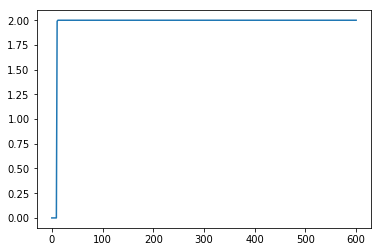

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def fopdt(t, K, tau, theta):
    return K*(1 - np.exp(-(t-theta)/tau))*(t > theta)


t = np.linspace(0,600,400)

y = fopdt(t, 2, .1, 10)

plt.plot(t, y)

## PID Reference Implementation

In [1]:
def PID(Kp, Ki, Kd, MV_bar=0, beta=1, gamma=0):
    # initialize stored data
    t_prev = -100
    P = 0
    I = 0
    D = 0
    S = 0
    N = 5
    
    # initial control
    MV = MV_bar
    
    while True:
        # yield MV, wait for new t, SP, PV, TR
        data = yield MV
        
        # see if a tracking data is being supplied
        if len(data) < 4:
            t, SP, PV = data
        else:
            t, SP, PV, TR = data
            I = TR - MV_bar - P - D
        
        # PID calculations
        P = Kp*(beta*SP - PV)
        I = I + Ki*(SP - PV)*(t - t_prev)
        eD = gamma*SP - PV
        D = N*Kp*(Kd*eD - S)/(Kd + N*Kp*(t - t_prev))
        MV = MV_bar + P + I + D
        
        # Constrain MV to range 0 to 100 for anti-reset windup
        MV = 0 if MV < 0 else 100 if MV > 100 else MV
        I = MV - MV_bar - P - D
        
        # update stored data for next iteration
        S = D*(t - t_prev) + S
        t_prev = t

## AMIGO Tuning


### KLT Model - First Order with Dead Time

AMIGO tuning assumes a so-called KLT process model with three parameters

\begin{align}
\tau \frac{d y}{dt} + y = K u(t-\theta)
\end{align}

where $y$ is the deviation of the process variable from a nominal steady-state value ($PV - \overline{PV}$), $u$ is a deviation in the manipulated manipulated variable from a nominal value ($MV - \overline{MV}$), and the parameters have the following descriptions.

| | |
| :-: | :-: |
|$K$| static gain |
|$\tau$| first-order time constant  (T, or Time constant)
|$\theta$| time-delay (L, or Lag)

These parameters can be determined from step testing.

### Tuning Rules

The AMIGO tuning rules provide values for the PID parameters $K_c$, $\tau_I$, $\tau_D$ in addition to setpoint weights $\beta$ and $\gamma$.

\begin{align}
K_c & = \frac{1}{K}\left(0.2 + 0.45\frac{\tau}{\theta}\right) \\
\\
\tau_I & = \frac{0.4\theta + 0.8\tau}{\theta + 0.1\tau}\theta \\
\\
\tau_D & = \frac{0.5\theta\tau}{0.3\theta + \tau} \\
\\
\beta & = \begin{cases} 0 & \theta \lt \tau \\ 1 & \theta \gt \tau \end{cases} \\
\\
\gamma & = 0
\end{align}

For proportional-integral (PI) control, the tuning rules are

\begin{align}
K_c & = \frac{1}{K}\left(0.15 + 0.35\frac{\tau}{\theta} - \frac{\tau^2}{(\theta + \tau)^2}\right) \\
\\
\tau_I & = \left(0.35 + \frac{13\tau^2}{\tau^2 + 12\theta\tau + 7\theta^2} \right)\theta \\
\\
\beta & = \begin{cases} 0 & \theta \lt \tau \\ 1 & \theta \gt \tau \end{cases} \\
\\
\gamma & = 0
\end{align}

Based on extensive simulation studies, the AMIGO tuning rules generally provide good performance for systems dynamics that are dominated by time lag $\theta > \tau$. The tuning rules are generally found to be overly conservative for $\theta < \tau$.

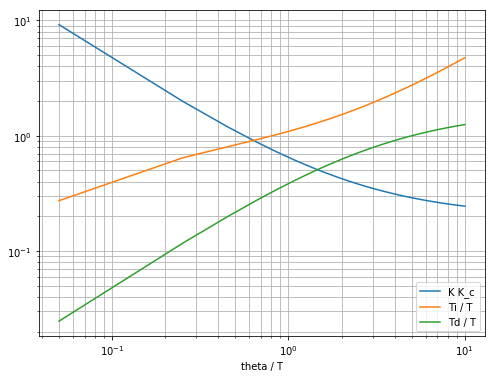

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

r = np.linspace(0.05,10)
kr = 0.2 + 0.45/r
ir = r*(0.4*r + 0.8)/(r + 0.1)
dr = 0.5*r/(0.3*r + 1)
plt.figure(figsize=(8,6))
plt.loglog(r,kr,r,ir,r,dr)
plt.legend(['K K_c','Ti / T','Td / T'])
plt.xlabel('theta / T')
plt.grid(True, which='both')

## Ziegler Nichols Tuning

## Relay Tuning

In [ ]:
def relay(SP, a = 5):
    MV = 0
    while True:
        PV = yield MV
        MV_prev = MV
        MV = 100 if PV < SP - a else 0 if PV > SP + a else MV_prev

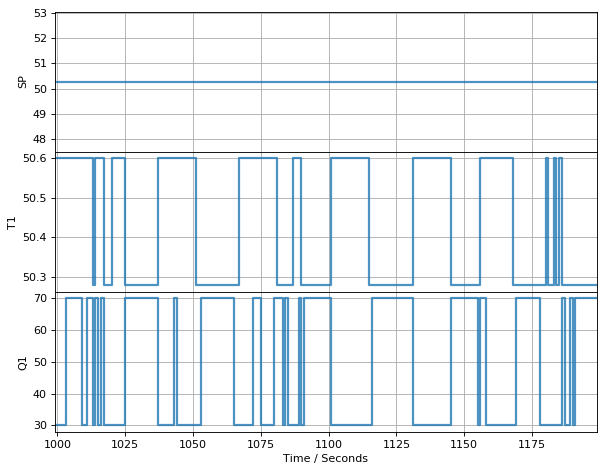

TCLab Model disconnected successfully.


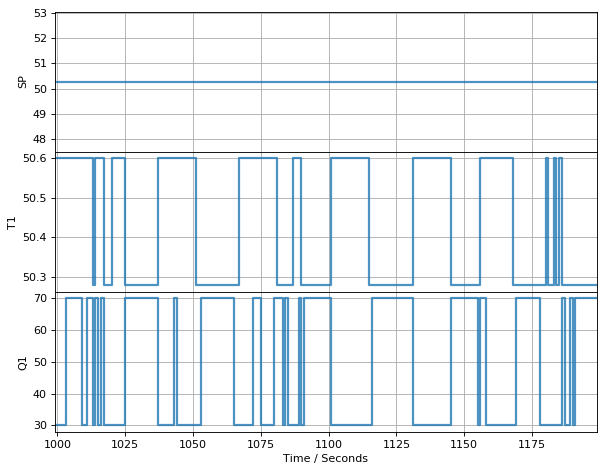

In [4]:
%matplotlib inline
from tclab import clock, setup, Historian, Plotter

TCLab = setup(connected=False, speedup=20)

tfinal = 1200
MV_bar = 50
hMV = 20

with TCLab() as lab:
    h = Historian([('SP', lambda: SP), ('T1', lambda: lab.T1), ('Q1', lab.Q1)])
    p = Plotter(h, 200)
    T1 = lab.T1
    for t in clock(tfinal, 1):
        if t < 600:
            SP = lab.T1
            MV = MV_bar
        else:
            MV = (MV_bar - hMV) if (lab.T1 > SP) else (MV_bar + hMV)
        lab.Q1(MV)
        p.update(t)                                   # update information display

In [14]:
Pu = 140
h = 20
a = 1.5

Ku = 4*h/a/3.14


In [15]:
Ku

16.985138004246284

In [19]:
Kp = Ku/2
Ti = Pu/2
Td = Pu/8

Ki = Kp/Ti
Kd = Kp*Td
print(Kp, Ki, Kd)

8.492569002123142 0.12132241431604489 148.619957537155


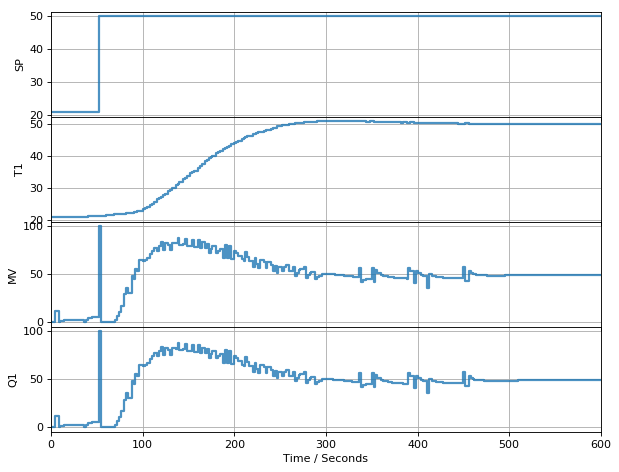

TCLab Model disconnected successfully.


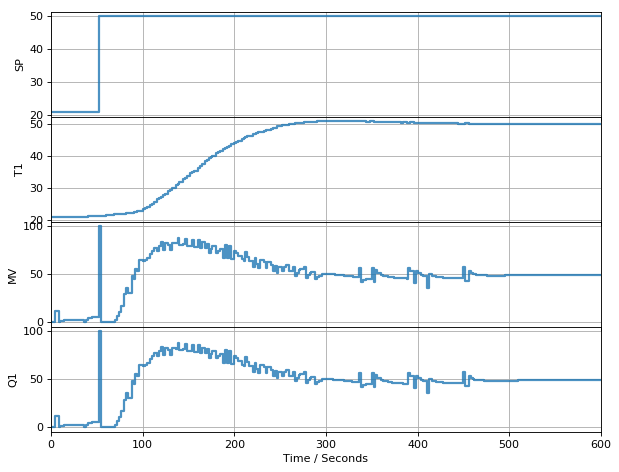

In [24]:
%matplotlib inline
from tclab import clock, setup, Historian, Plotter

TCLab = setup(connected=False, speedup=10)

controller = PID(Kp, Ki, Kd, beta=1, gamma=1)   # create pid control
controller.send(None)                 # initialize

tfinal = 600

with TCLab() as lab:
    h = Historian([('SP', lambda: SP), ('T1', lambda: lab.T1), ('MV', lambda: MV), ('Q1', lab.Q1)])
    p = Plotter(h, tfinal)
    T1 = lab.T1
    for t in clock(tfinal, 2):
        SP = T1 if t < 50 else 50                     # get setpoint
        PV = lab.T1                                   # get measurement
        MV = controller.send([t, SP, PV])   # compute manipulated variable
        lab.Q1(MV)                                    # apply 
        p.update(t)                                   # update information display